# Linear case tests

Here we will test Adaptive filters in linear case.

This notebook is based on [Adaptive-Filtering](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/14-Adaptive-Filtering.ipynb) chapter of [the book](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python)

In [1]:
from __future__ import division, print_function
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

/home/anon/anaconda3/envs/KerasTfCuda/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


# Maneuvering target model

In [3]:
from math import sin, cos, radians

def angle_between(x, y):
  return min(y-x, y-x+360, y-x-360, key=abs)

class ManeuveringTarget(object): 
    def __init__(self, x0, y0, v0, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.hdg = heading
        
        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0
        
        
    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx
        self.y += vy
        
        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta
        return (self.x, self.y)
        

    def set_commanded_heading(self, hdg_degrees, steps):
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, 
                                       self.hdg) / steps
        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0
            
            
    def set_commanded_speed(self, speed, steps):
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps
        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0    

# Sensor model

In [4]:
from numpy.random import randn

class NoisySensor(object):
    def __init__(self, std_noise=1.):
        self.std = std_noise

    def sense(self, pos):
        """Pass in actual position as tuple (x, y).       
        Returns position with noise added (x,y)"""
        
        return (pos[0] + (randn() * self.std), 
                pos[1] + (randn() * self.std))

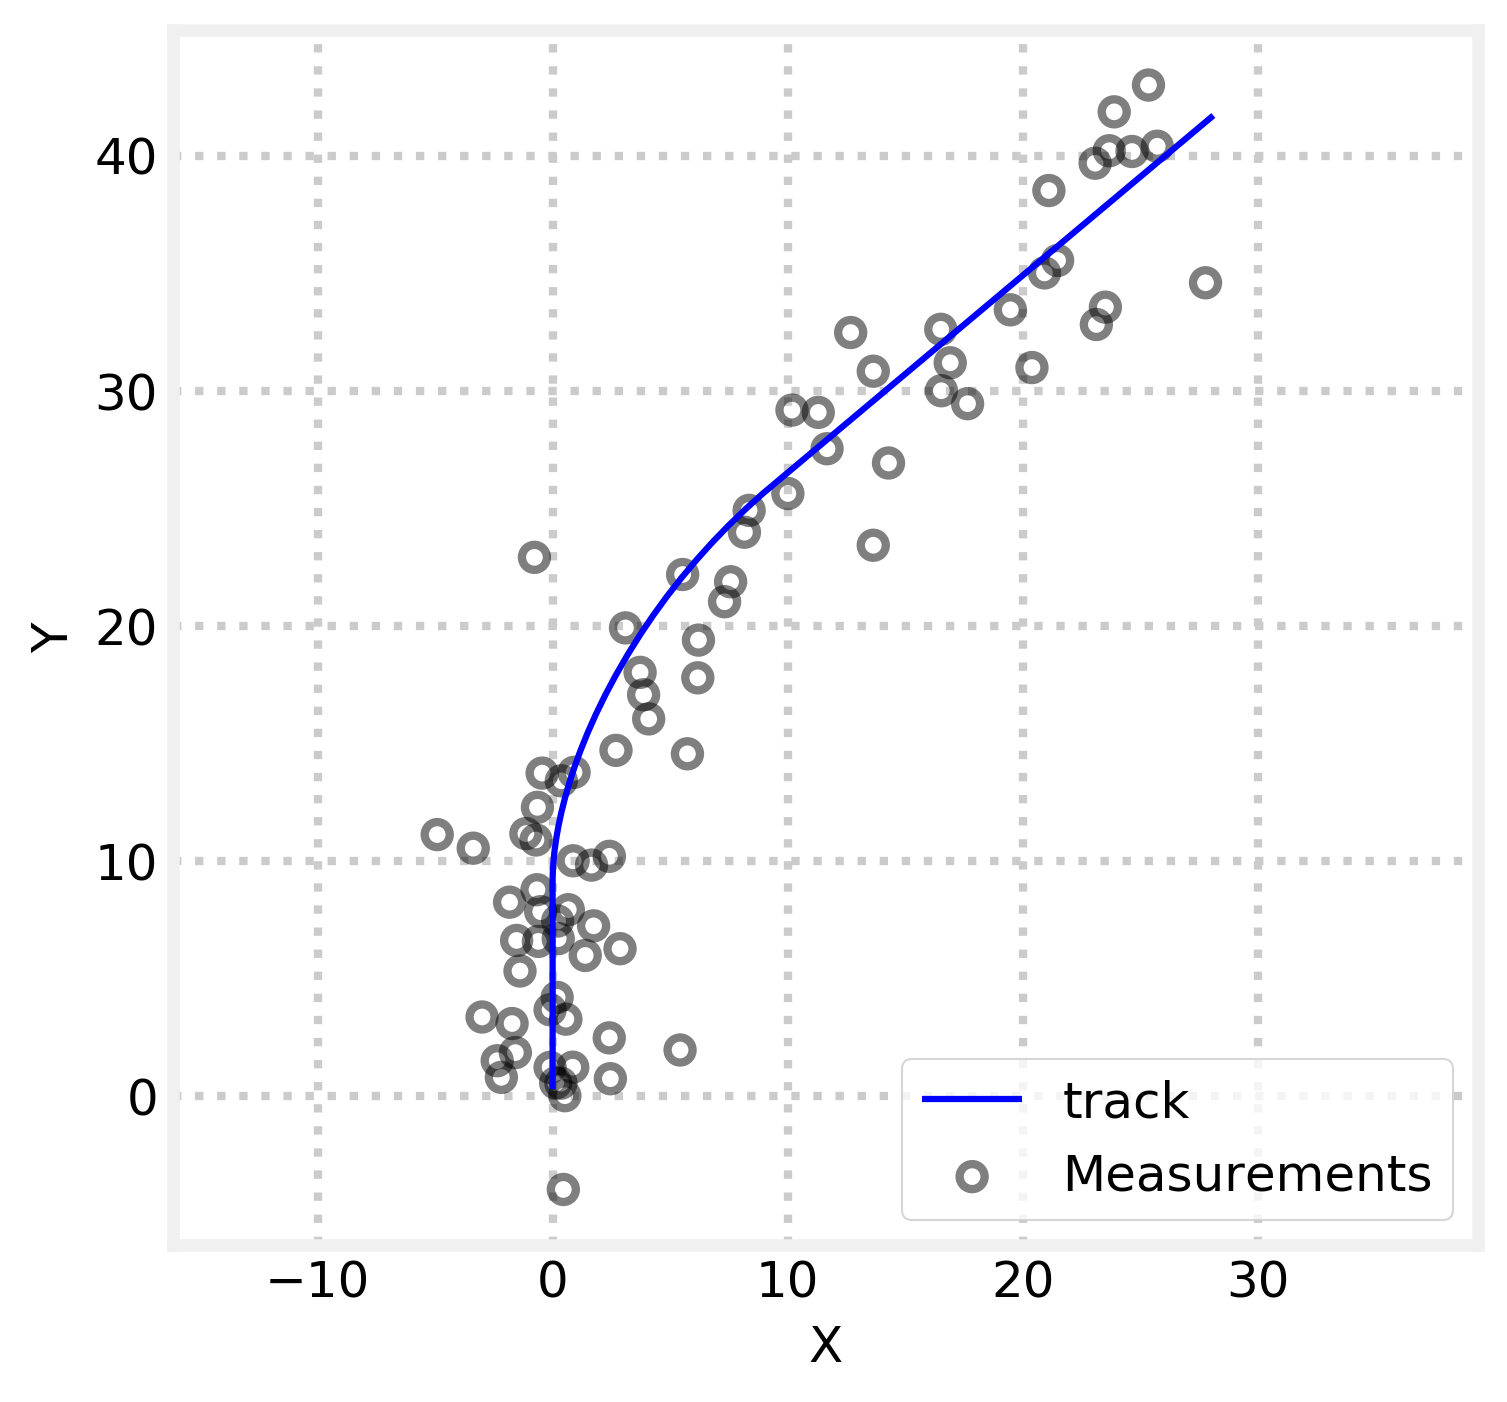

In [5]:
import kf_book.book_plots as bp
import numpy as np
import matplotlib.pyplot as plt

def generate_data(steady_count, std):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(std)
    pos = np.array(list(zip(xs, ys)))
    zs = np.array([ns.sense(p) for p in pos])
    return pos, zs

sensor_std = 2.
track, zs = generate_data(50, sensor_std)
plt.figure(figsize=(5, 5), dpi=300.0)
bp.plot_measurements(*zip(*zs), alpha=0.5)
plt.plot(*zip(*track), color='b', label='track')
plt.axis('equal')
plt.legend(loc=4)
bp.set_labels(title='', x='X', y='Y')


# Compare different filters

In [6]:
from EKHFPrior import ExtendedKalmanHinfFilterPrior as EKHF_A
from UDEKHFPrior import UDExtendedKalmanHinfFilterPrior as UDEKHF_A

from EKHFPost import ExtendedKalmanHinfFilterPosterior as EKHF_B
from UDEKHFPost import UDExtendedKalmanHinfFilterPosterior as UDEKHF_B

from EKHFPrior2 import ExtendedKalmanHinfFilterPrior2 as EKHF_C
from UDEKHFPrior2 import UDExtendedKalmanHinfFilterPrior2 as UDEKHF_C

from EKHFPost2 import ExtendedKalmanHinfFilterPosterior2 as EKHF_D
from UDEKHFPost2 import UDExtendedKalmanHinfFilterPosterior2 as UDEKHF_D

from filterpy.kalman import ExtendedKalmanFilter as EKF
from filterpy.common import Q_discrete_white_noise

cv_filter_H = np.array([[1., 0., 0., 0.],
                        [0., 0., 1., 0.]], dtype=float)

def cv_filter_Hx(x, *args):
    return cv_filter_H.dot(x)

def cv_filter_HJacobian(x, *args):
    return cv_filter_H

def make_cv_filter(dt, std, ftype):
    cvfilter = ftype(dim_x = 4, dim_z=2)
    cvfilter.x = np.array([0., 0., 0., 0.])
    cvfilter.P *= 3
    cvfilter.R *= std**2
    cvfilter.F = np.array([[1., dt, 0., 0.],
                           [0., 1., 0., 0.],
                           [0., 0., 1., dt],
                           [0., 0., 0., 1]], dtype=float)
    #We have to add the regularization term to Q_discrete_white_noise or udu(Q) won't exist.
    cvfilter.Q = Q_discrete_white_noise(dim=4, dt=dt, var=0.02)
    cvfilter.Q += cvfilter.Q * np.eye(4) * 0.000000001 #Make Q positive definite
    return cvfilter

def initialize_filter(kf, std_R=None):
    """ helper function - we will be reinitialing the filter
    many times.
    """
    kf.x.fill(0.)
    kf.P = np.eye(kf.dim_x) * .1
    if std_R is not None:
        kf.R = np.eye(kf.dim_z) * std_R

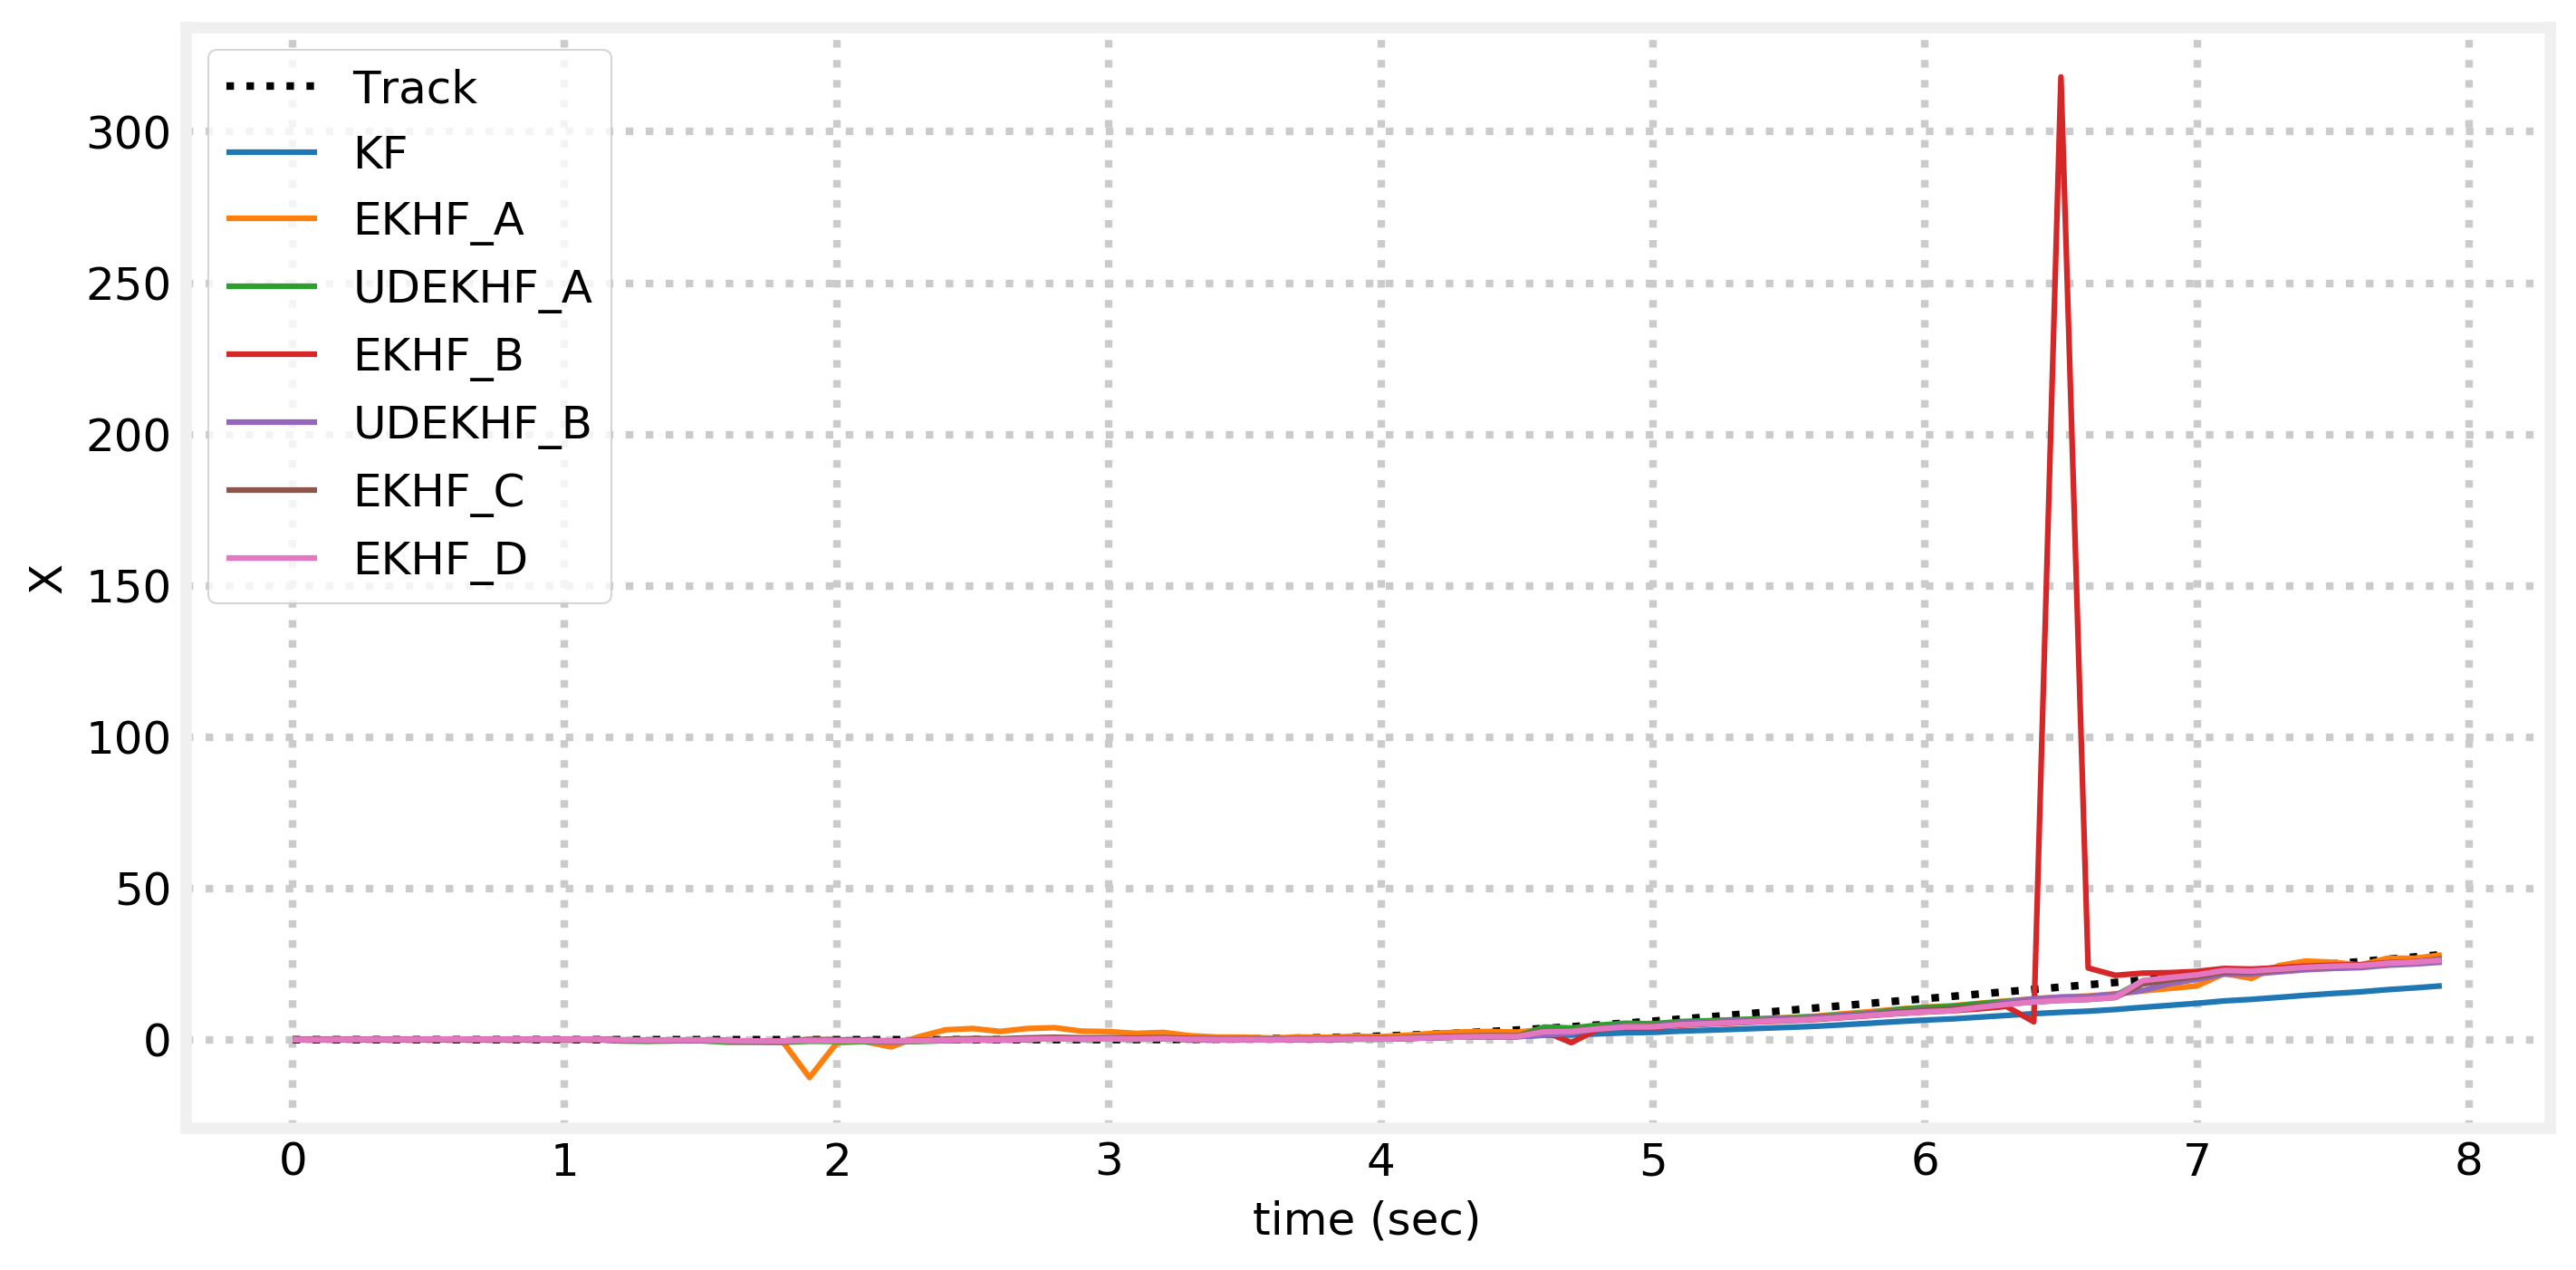

In [7]:
sensor_std = 2.
dt = 0.1

filters = {
    'KF':EKF,
    'EKHF_A':EKHF_A,
    'UDEKHF_A':UDEKHF_A,
    'EKHF_B':EKHF_B,
    'UDEKHF_B':UDEKHF_B,
    'EKHF_C':EKHF_C,
    'EKHF_D':EKHF_D
}

track, zs = generate_data(50, sensor_std)
z_xs     = zs#zs[:, 0]

plt.figure(figsize=(10, 5), dpi=300.0)
bp.plot_track(track[:, 0], dt=dt)

for fname in list(filters):
    # initialize filter
    try:
        cvfilter = make_cv_filter(dt, sensor_std, filters[fname])
        initialize_filter(cvfilter)
    
        # run filter
        kxs = []
        for z in z_xs:
            cvfilter.predict_update(z, cv_filter_HJacobian, cv_filter_Hx)
            kxs.append(cvfilter.x_post)
        kxs = np.array(kxs)
        bp.plot_filter(kxs[:, 0], dt=dt, label=fname, c = None)
    except:
        continue

bp.set_labels(title='', x='time (sec)', y='X');
plt.legend(loc=2);

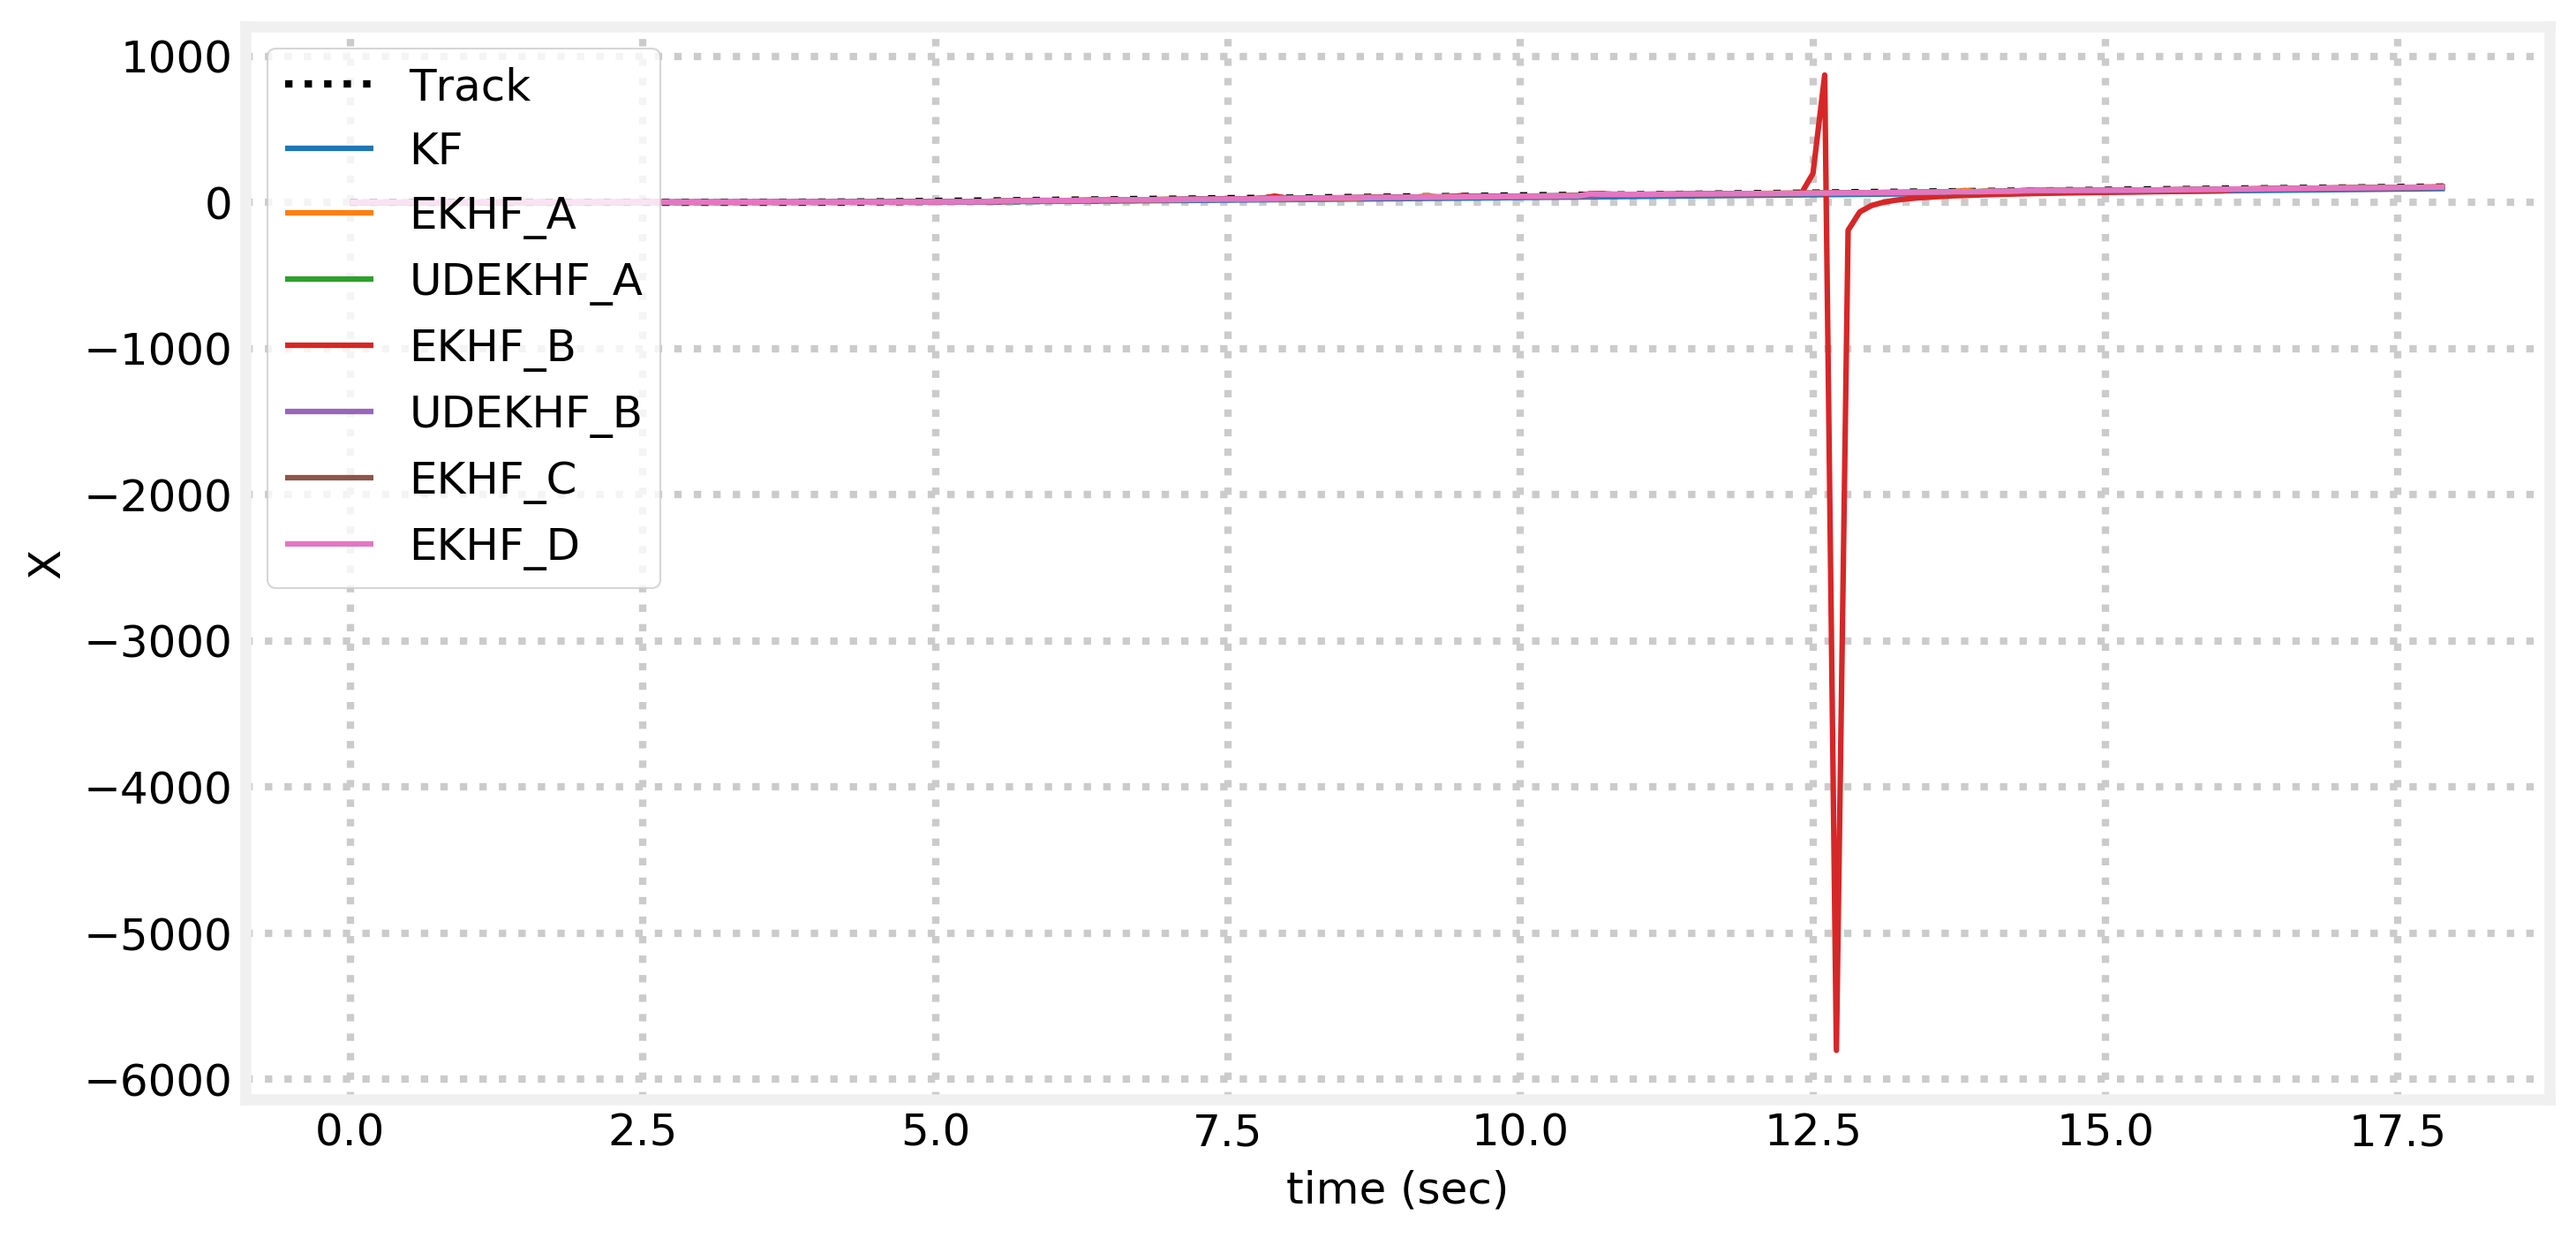

In [8]:
# reinitialize filter
dt = 0.1

track2, zs2 = generate_data(150, sensor_std)
z_xs2     = zs2[:, 0]

plt.figure(figsize=(10, 5), dpi=300.0)
bp.plot_track(track2[:, 0], dt=dt)

for fname in list(filters):
    try:
        # initialize filter
        cvfilter = make_cv_filter(dt, sensor_std, filters[fname])
        initialize_filter(cvfilter)
        # run filter
        kxs = []
        for z in z_xs2:
            cvfilter.predict_update(z, cv_filter_HJacobian, cv_filter_Hx)
            kxs.append(cvfilter.x_post)
        kxs = np.array(kxs)
        bp.plot_filter(kxs[:, 0], dt=dt, label=fname, c = None)
    except:
        continue

bp.set_labels(title='', x='time (sec)', y='X');
plt.legend(loc=2);

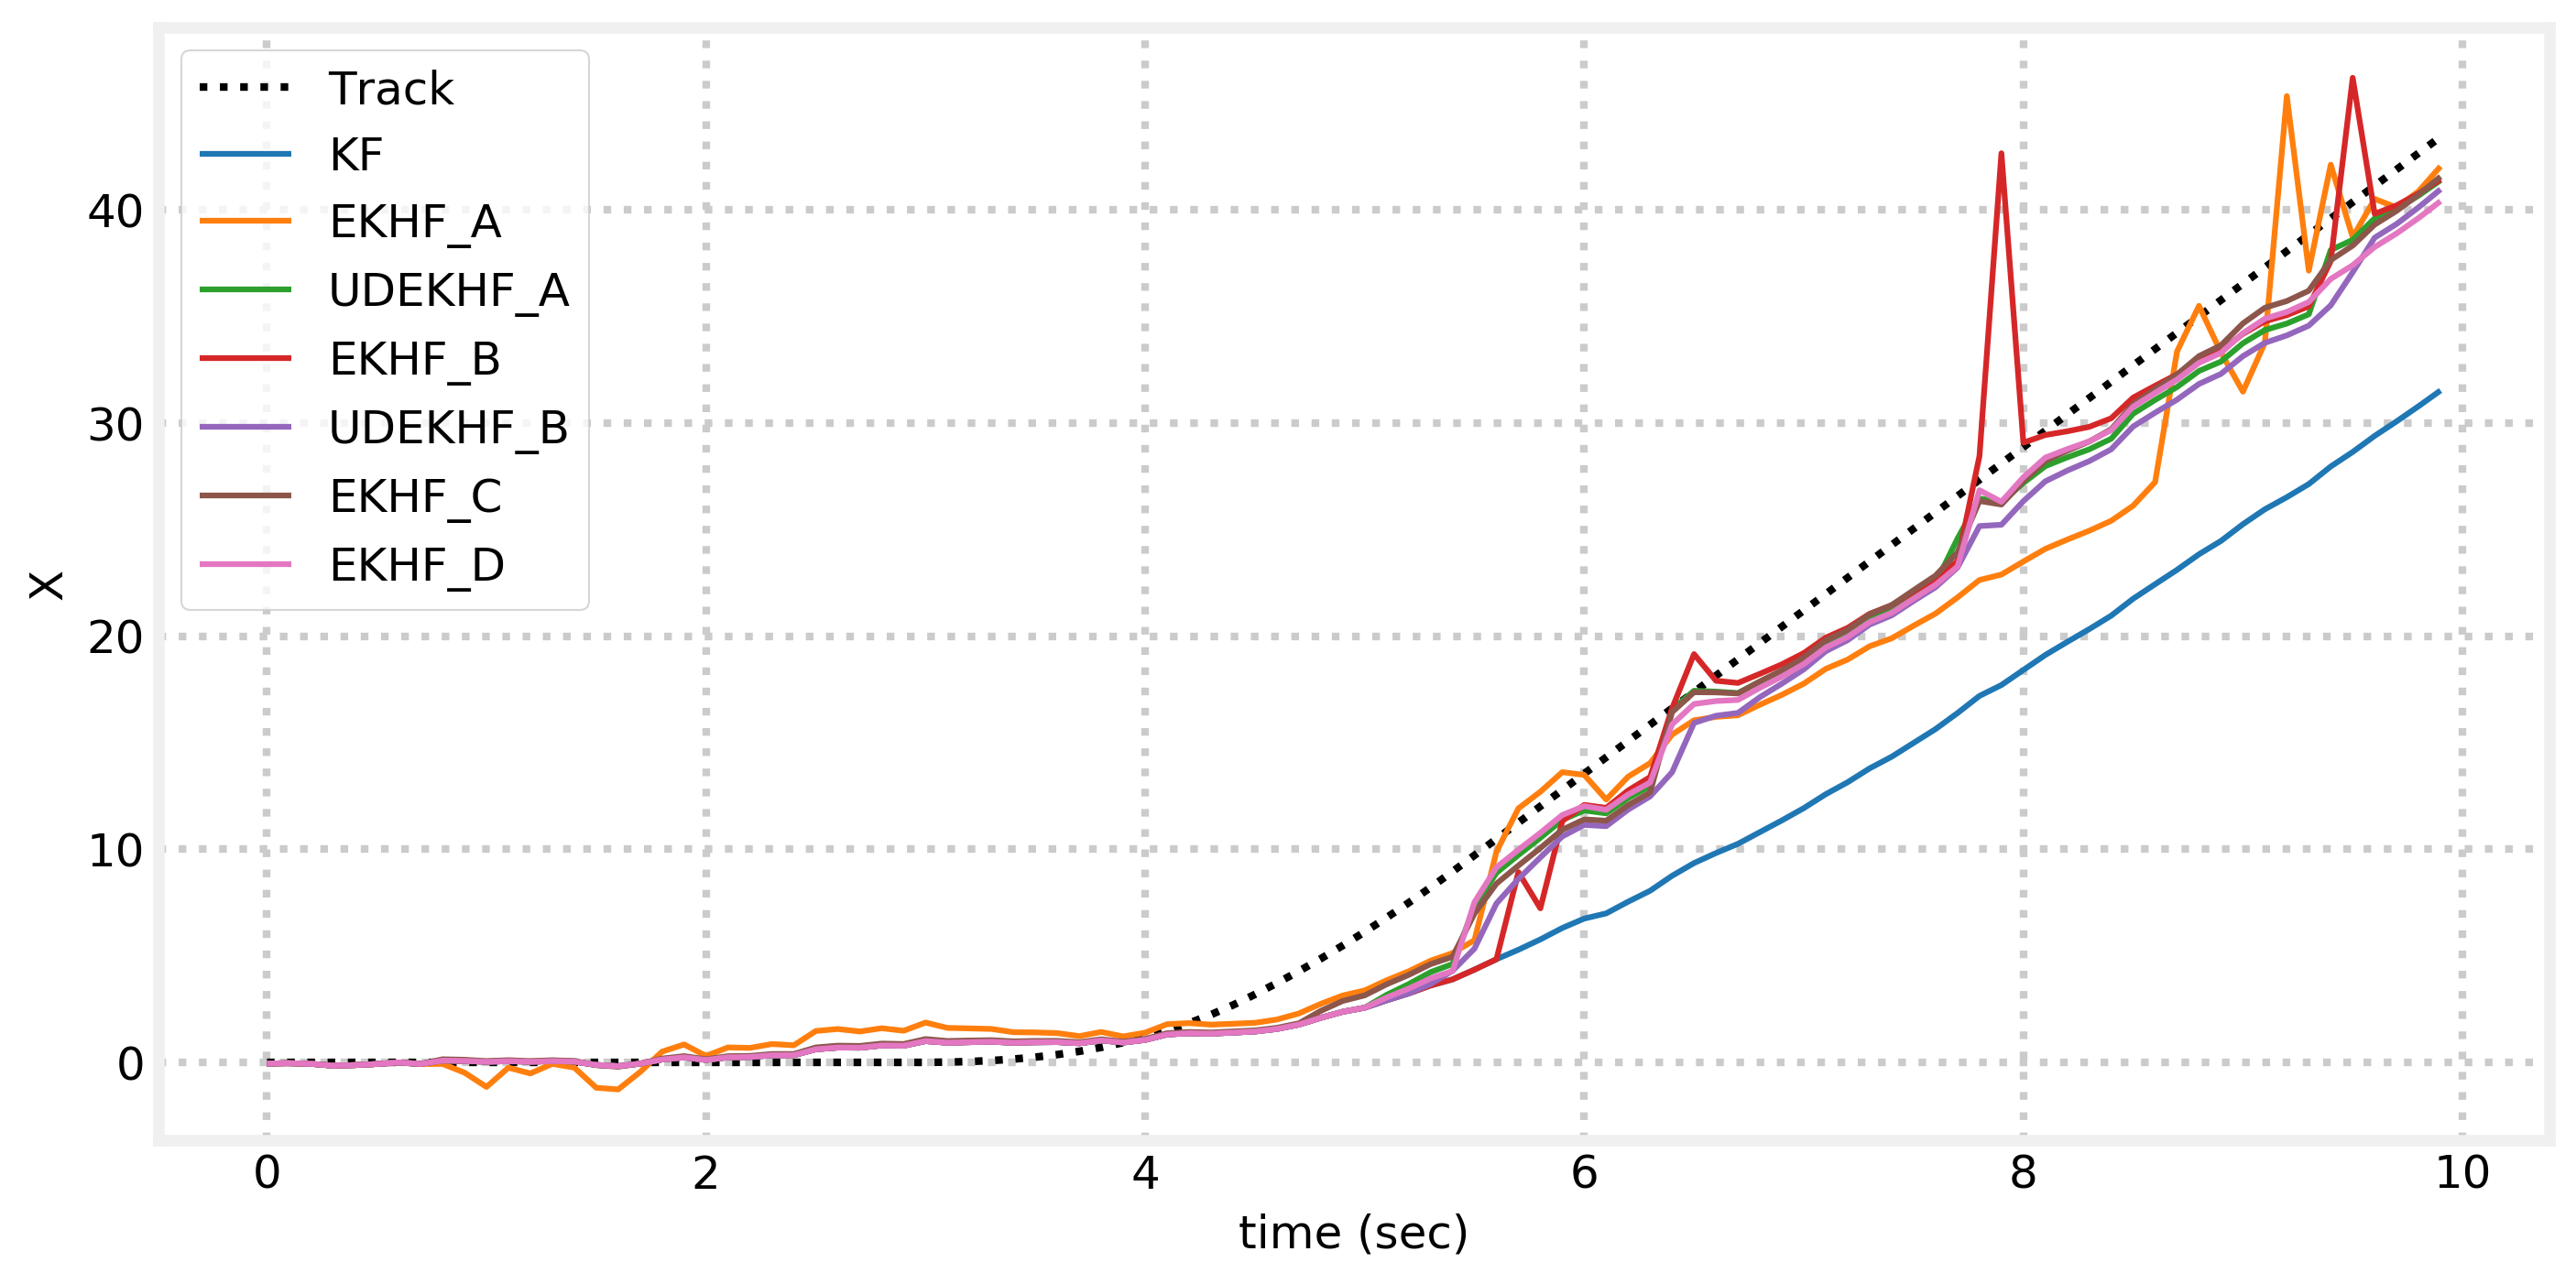

In [9]:
# reinitialize filter
plt.figure(figsize=(10, 5), dpi=300.0)
bp.plot_track(track2[:100, 0], dt=dt)

for fname in list(filters):
    try:
        # initialize filter
        cvfilter = make_cv_filter(dt, sensor_std, filters[fname])
        initialize_filter(cvfilter)
        # run filter
        kxs = []
        for z in z_xs2[:100]:
            cvfilter.predict_update(z, cv_filter_HJacobian, cv_filter_Hx)
            kxs.append(cvfilter.x_post)
        kxs = np.array(kxs)
        bp.plot_filter(kxs[:, 0], dt=dt, label=fname, c = None)
    except:
        continue

bp.set_labels(title='', x='time (sec)', y='X');
plt.legend(loc=2);

### Findings
* EKHF_B fails to correct KF
* EKHF_A gives most accurate result
* UDEKHF_B seems to be most smooth in current conditions

## Compare adaptive filters with Kalman with different sensor noise sdt


In [10]:
def plot_track_and_residuals(dt, sensor_std, z_xs, xs_ref, res_ref, xs, res, fname):
    """ plots track and measurement on the left, and the residual
    of the filter on the right. Helps to visualize the performance of
    an adaptive filter.
    """
    
    assert np.isscalar(dt)
    t = np.arange(0, len(xs)*dt, dt)
    plt.subplot(121)
    if z_xs is not None:
        bp.plot_measurements(t, z_xs, label='z')
    bp.plot_filter(t, xs_ref, c = None, label='KF')
    bp.plot_filter(t, xs, c = None, label=str(fname))
    plt.legend(loc=2)
    plt.xlabel('time (sec)')
    plt.ylabel('X')
    plt.title('estimates (sdt = %.e)'%sensor_std)
    plt.subplot(122)
    # plot twice so it has the same color as the plot to the left!
    plt.plot(t, res_ref)
    plt.plot(t, res)
    plt.xlabel('time (sec)')
    #plt.ylabel('residual')
    plt.title('residuals')
plt.show()

def _compare_residual_charts(dt, sensor_std, ftype, fname):
    # initialize filter
    cvfilter_kf = make_cv_filter(dt, sensor_std, EKF)
    initialize_filter(cvfilter_kf)
    
    cvfilter = make_cv_filter(dt, sensor_std, ftype)
    initialize_filter(cvfilter)
    
    pos, zs = generate_data(150, sensor_std)
    xs = pos#pos[:, 0]
    z_xs = zs#zs[:, 0]
    
    xs, res = [], []
    xs_kf, res_kf = [], []
    for z in z_xs:
        cvfilter_kf.predict()
        #cvfilter_kf.update([z], cv_filter_HJacobian, cv_filter_Hx)
        cvfilter_kf.update(z, cv_filter_HJacobian, cv_filter_Hx)
        xs_kf.append(cvfilter_kf.x[0])
        res_kf.append(cvfilter_kf.y[0])

        cvfilter.predict()
        #cvfilter.update([z], cv_filter_HJacobian, cv_filter_Hx)
        cvfilter.update(z, cv_filter_HJacobian, cv_filter_Hx)
        xs.append(cvfilter.x[0])
        res.append(cvfilter.y[0])
        
    xs_kf  = np.asarray(xs_kf)
    res_kf = np.asarray(res_kf)
    xs     = np.asarray(xs)
    res    = np.asarray(res)
    plot_track_and_residuals(dt, sensor_std, z_xs[:, 0], xs_kf, res_kf, xs, res, fname)

def compare_residual_charts(dt, sensor_std, ftype, fname):
    try:
        _compare_residual_charts(dt, sensor_std, ftype, fname)
    except:
        print('fail')
    
dt = 0.1

### EKHF_A

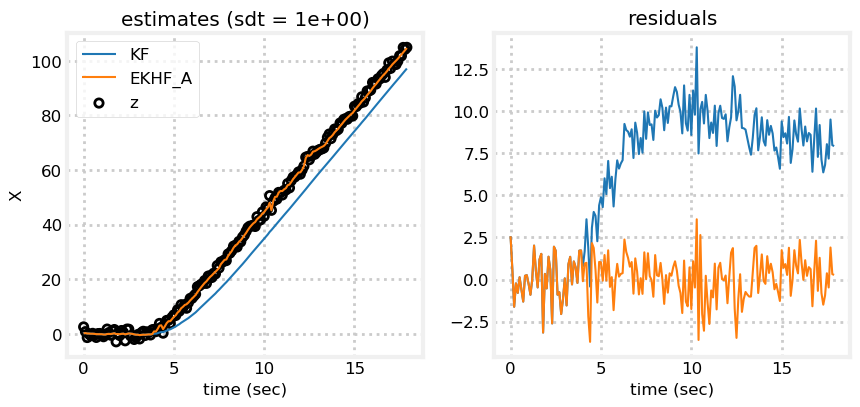

In [11]:
compare_residual_charts(dt, 1., EKHF_A, 'EKHF_A')

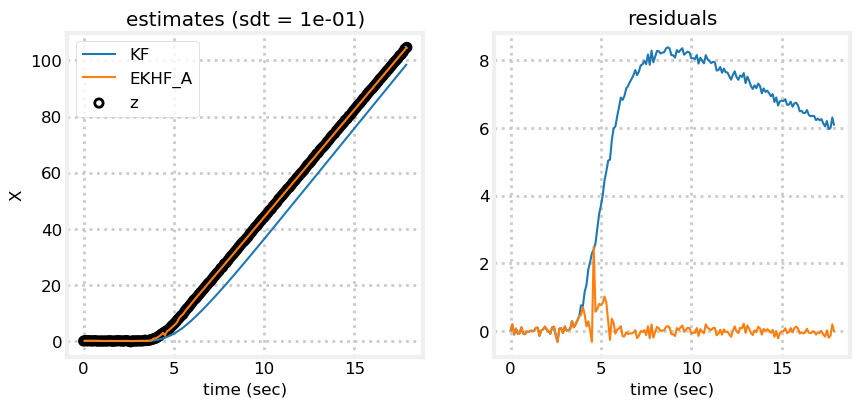

In [12]:
compare_residual_charts(dt, .1, EKHF_A, 'EKHF_A')

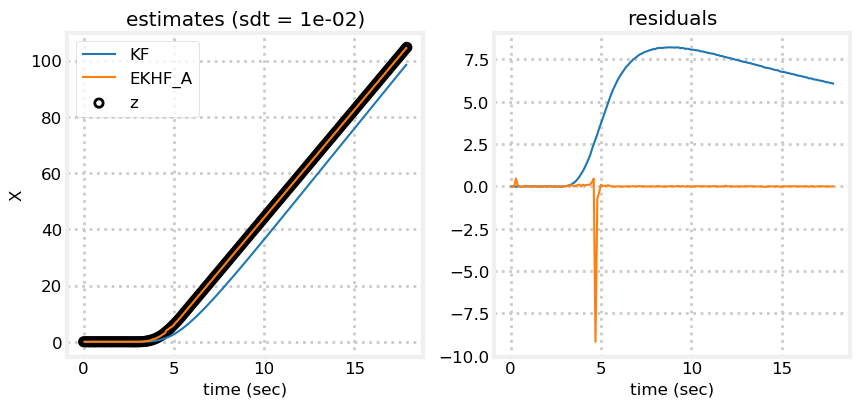

In [13]:
compare_residual_charts(dt, .01, EKHF_A, 'EKHF_A')

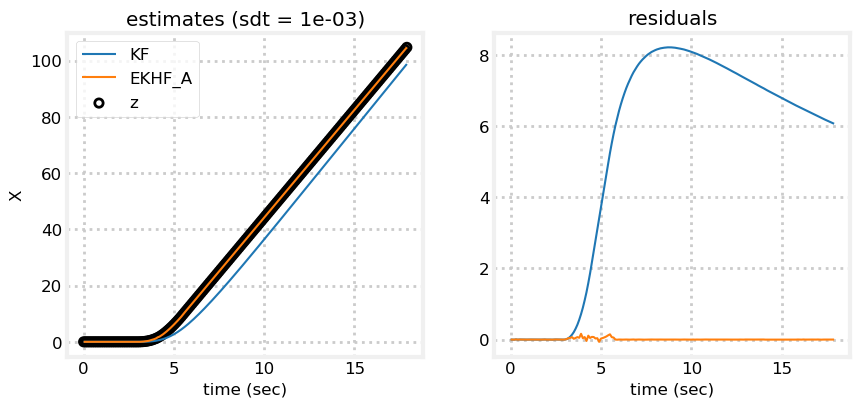

In [14]:
compare_residual_charts(dt, .001, EKHF_A, 'EKHF_A')

### UDEKHF_A

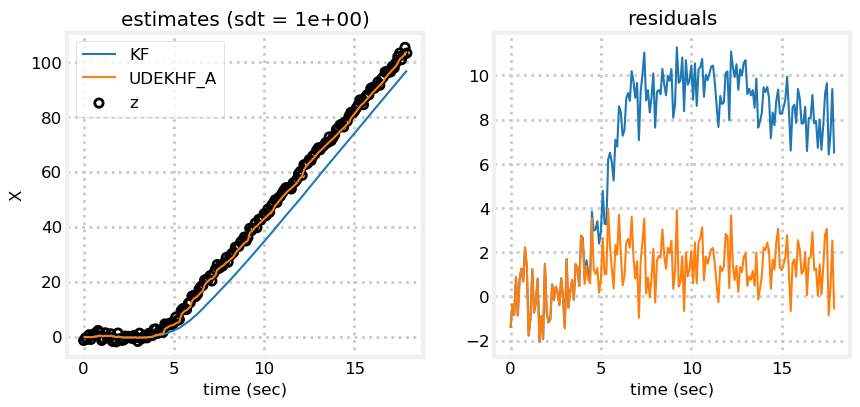

In [15]:
compare_residual_charts(dt, 1., UDEKHF_A, 'UDEKHF_A')

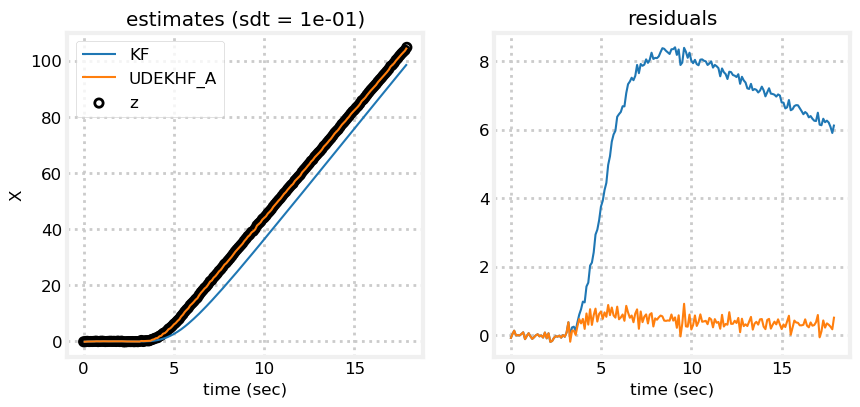

In [16]:
compare_residual_charts(dt, .1, UDEKHF_A, 'UDEKHF_A')

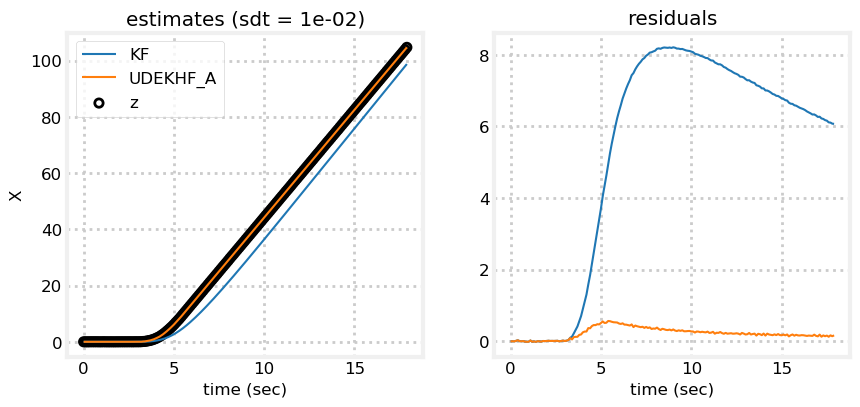

In [17]:
compare_residual_charts(dt, .01, UDEKHF_A, 'UDEKHF_A')

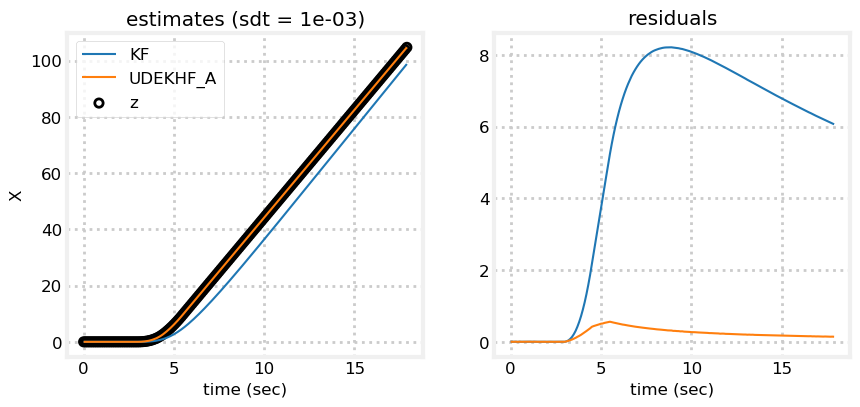

In [18]:
compare_residual_charts(dt, .001, UDEKHF_A, 'UDEKHF_A')

### Findings
* EKHF_A and UDEKHF_A appear to be stable with different values of sensor_std
* EKHF_A gives sudden spikes in some points

### EKHF_B

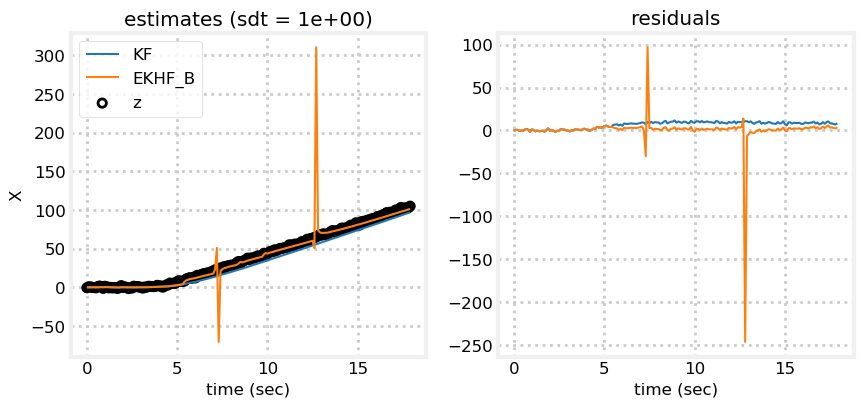

In [19]:
compare_residual_charts(dt, 1., EKHF_B, 'EKHF_B')

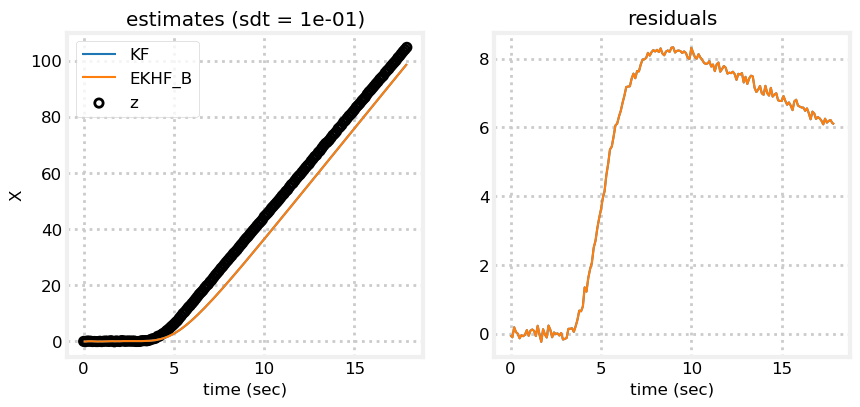

In [20]:
compare_residual_charts(dt, .1, EKHF_B, 'EKHF_B')

### Findings
* EKHF_B fails to correct KF

### UDEKHF_B

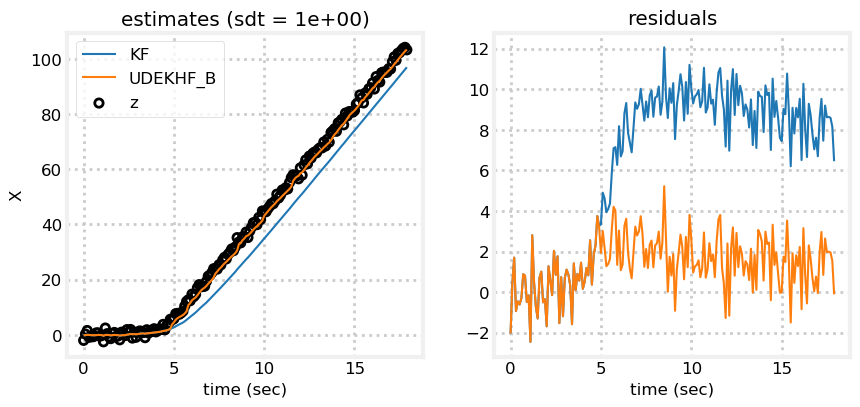

In [21]:
compare_residual_charts(dt, 1., UDEKHF_B, 'UDEKHF_B')

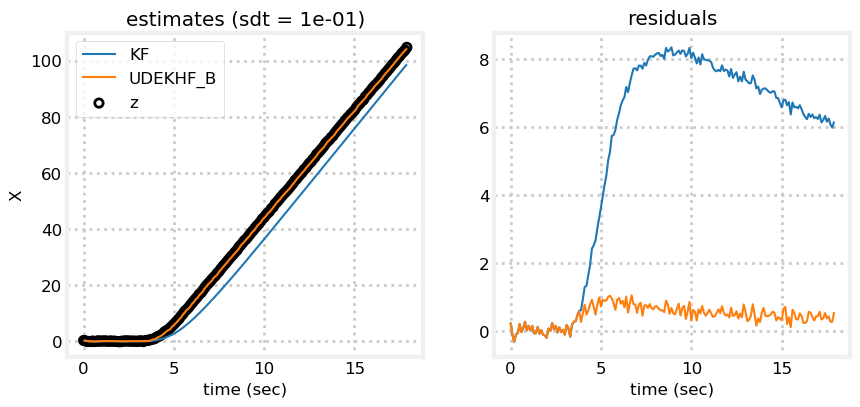

In [22]:
compare_residual_charts(dt, .1, UDEKHF_B, 'UDEKHF_B')

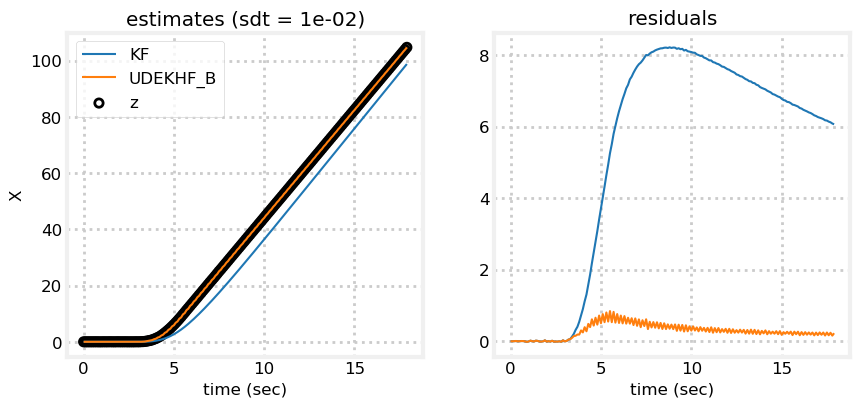

In [23]:
compare_residual_charts(dt, .01, UDEKHF_B, 'UDEKHF_B')

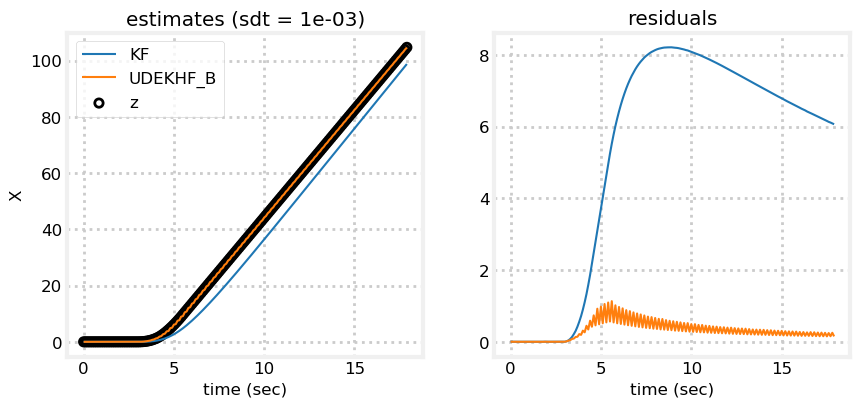

In [24]:
compare_residual_charts(dt, .001, UDEKHF_B, 'UDEKHF_B')

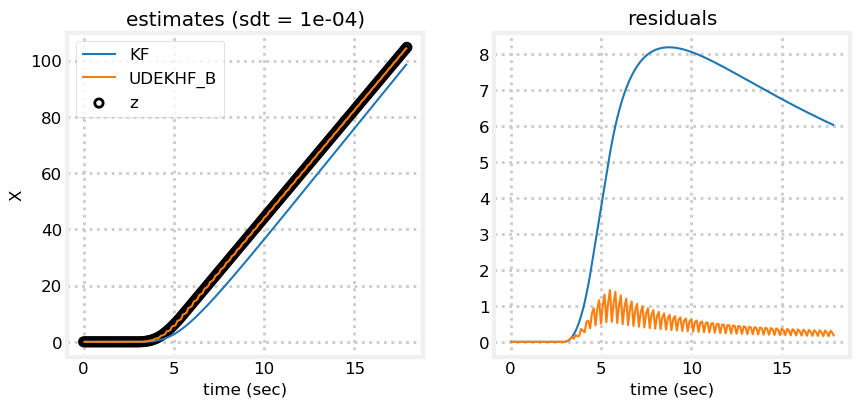

In [25]:
compare_residual_charts(dt, .0001, UDEKHF_B, 'UDEKHF_B')

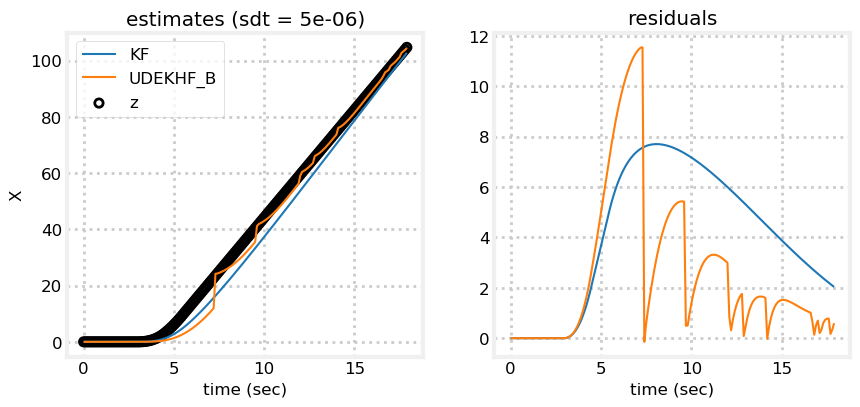

In [26]:
compare_residual_charts(dt, .000005002, UDEKHF_B, 'UDEKHF_B')

### Findings
* Despite the fact that UDEKHF_B does not fail and can correct KF it demonstartes unstable behaviour, residuals bounce with small sensor_std

### EKHF_C

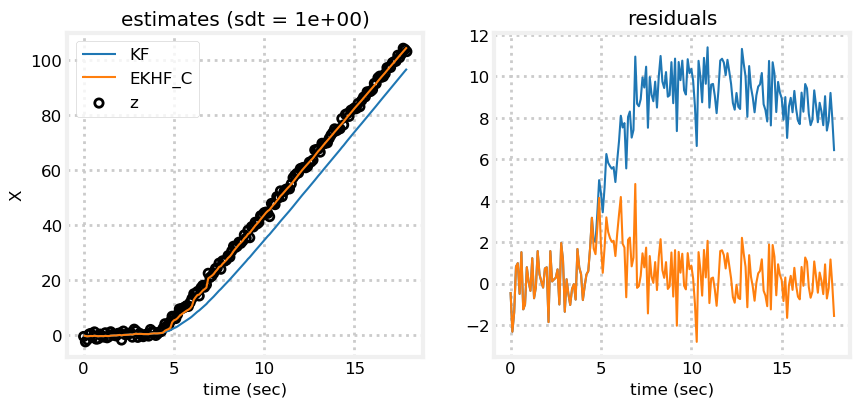

In [27]:
compare_residual_charts(dt, 1., EKHF_C, 'EKHF_C')

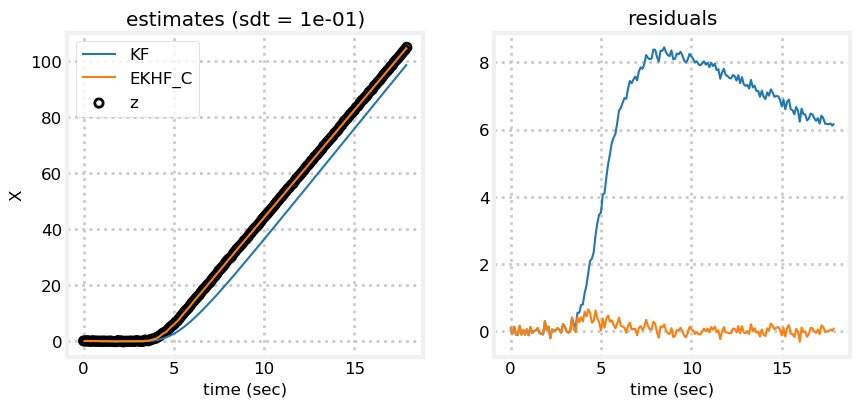

In [28]:
compare_residual_charts(dt, .1, EKHF_C, 'EKHF_C')

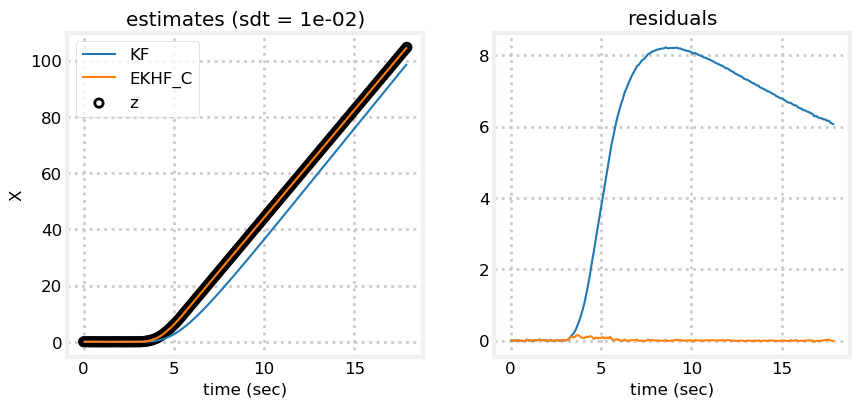

In [29]:
compare_residual_charts(dt, .01, EKHF_C, 'EKHF_C')

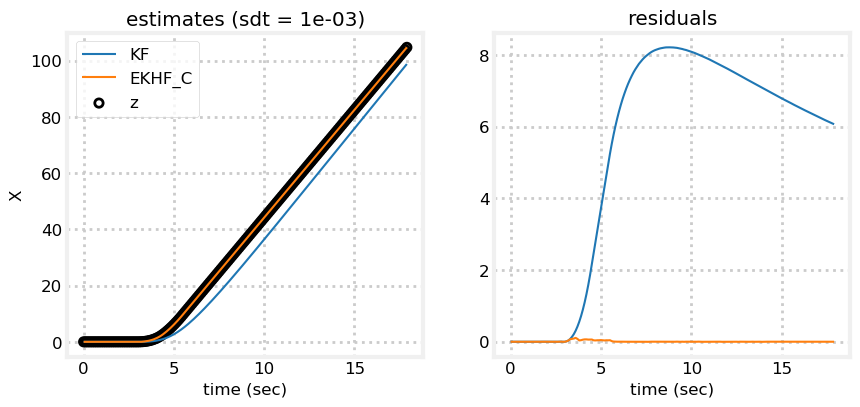

In [30]:
compare_residual_charts(dt, .001, EKHF_C, 'EKHF_C')

# EKHF_D

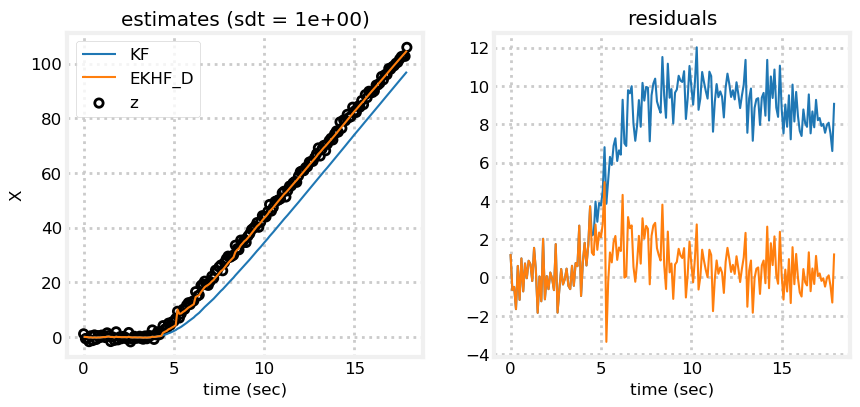

In [31]:
compare_residual_charts(dt, 1., EKHF_D, 'EKHF_D')

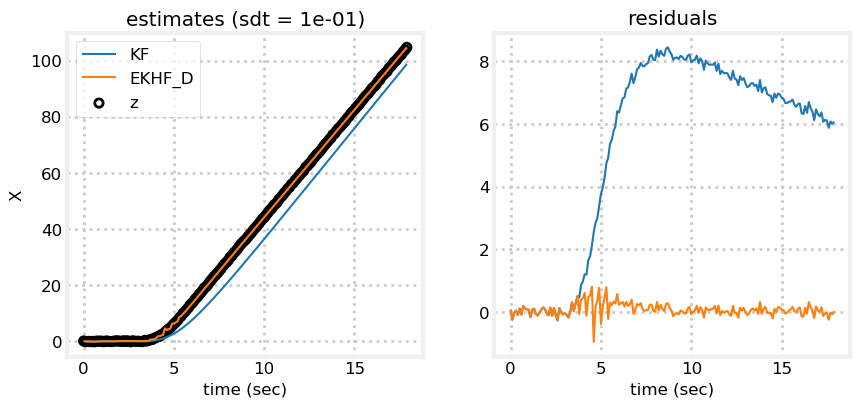

In [32]:
compare_residual_charts(dt, .1, EKHF_D, 'EKHF_D')

In [33]:
compare_residual_charts(dt, .01, EKHF_D, 'EKHF_D')

fail


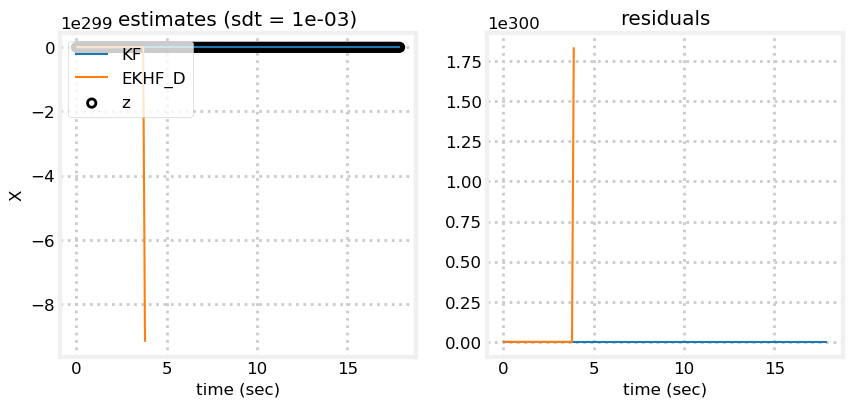

In [34]:
compare_residual_charts(dt, .001, EKHF_D, 'EKHF_D')

# UDEKHF_C

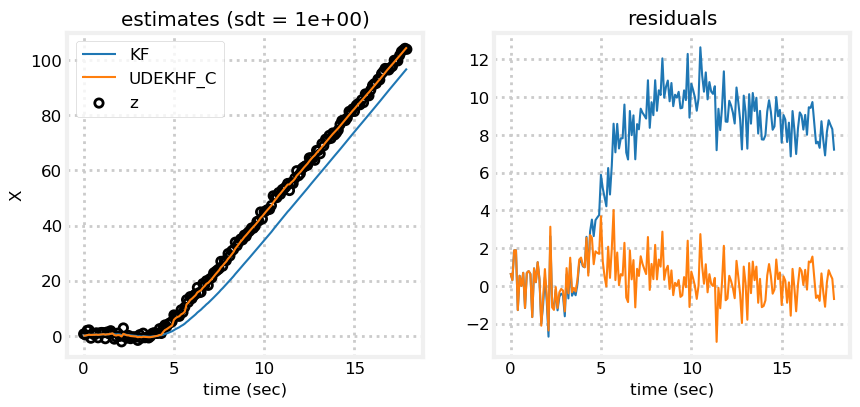

In [36]:
compare_residual_charts(dt, 1., UDEKHF_C, 'UDEKHF_C')

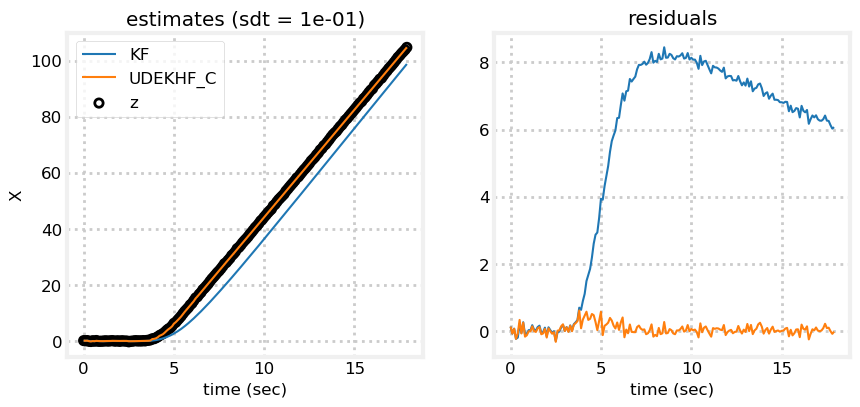

In [37]:
compare_residual_charts(dt, .1, UDEKHF_C, 'UDEKHF_C')

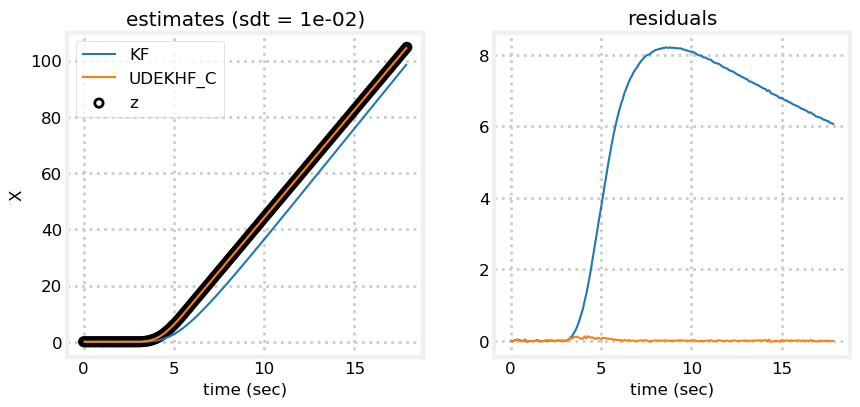

In [38]:
compare_residual_charts(dt, .01, UDEKHF_C, 'UDEKHF_C')

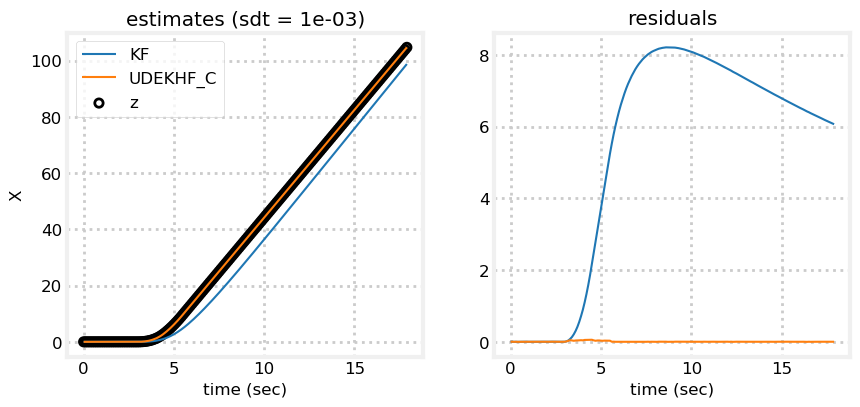

In [39]:
compare_residual_charts(dt, .001, UDEKHF_C, 'UDEKHF_C')